In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor
from datetime import datetime, timedelta
from sklearn.model_selection import GroupKFold

In [2]:
data_path = 'TaxiData/'
gps_point = pd.read_csv(data_path + 'train_gps_points.csv')
train_df = pd.read_csv(data_path + 'train_hire_stats_new.csv', index_col=0)
test_df = pd.read_csv(data_path + 'test_hire_stats_new.csv', index_col=0)
train_df

,Zone_ID,Date,Hour_slot,Hire_count,Temperature,RH,Precp
0,1,2016-02-01,0,0,16.7,76.0,0.0
1,1,2016-02-01,1,0,15.6,92.0,0.0
2,1,2016-02-01,2,0,14.8,98.0,0.0
3,1,2016-02-01,3,0,14.5,100.0,0.0
4,1,2016-02-01,4,0,15.1,99.0,0.0
...,...,...,...,...,...,...,...
219595,25,2017-01-31,19,26,19.7,85.0,0.0
219596,25,2017-01-31,20,20,19.3,86.0,0.0
219597,25,2017-01-31,21,16,19.3,85.0,0.0
219598,25,2017-01-31,22,14,19.3,84.0,0.0


In [3]:
display(test_df)
test_df['Zone_ID'].unique().tolist()  # testing set 只要在這幾個區域預測

,Test_ID,Zone_ID,Date,Hour_slot,Hire_count,Temperature,RH,Precp
0,0,7,2017-02-01,0,NaN,14.5,82,0.0
1,1,7,2017-02-01,1,NaN,14.6,81,0.0
2,2,7,2017-02-01,2,NaN,14.6,79,0.0
3,3,7,2017-02-01,3,NaN,14.7,77,0.0
4,4,7,2017-02-01,4,NaN,14.6,80,0.0
...,...,...,...,...,...,...,...,...
6043,6043,19,2017-02-28,19,NaN,14.6,80,0.0
6044,6044,19,2017-02-28,20,NaN,14.7,79,0.0
6045,6045,19,2017-02-28,21,NaN,14.6,82,0.0
6046,6046,19,2017-02-28,22,NaN,14.7,84,0.0


[7, 8, 9, 12, 13, 14, 17, 18, 19]

In [4]:
def rmse(preds ,ys): return ((preds - ys) ** 2).mean() ** 0.5

# train

In [5]:
# Check weekday & workday
# holidays連假的平常日
# workdays連假的補班日

holidays = {
    '2016-02-08', '2016-02-09', '2016-02-10', '2016-02-11', '2016-02-12',
    '2016-02-29', '2016-04-04', '2016-04-05', '2016-06-09', '2016-06-10',
    '2016-09-15', '2016-09-16', '2016-10-10', '2017-01-02', '2017-01-27',
    '2017-01-30', '2017-02-01', '2017-02-27', '2017-02-28'
}
makeupworkdays = {'2016-06-04', '2016-09-10', '2017-02-18'}
malfunctiondays = {
    '2016-02-05', '2016-02-16', '2016-03-07', '2016-05-02', '2016-07-08',
    '2016-09-28', '2016-10-31', '2016-11-14', '2016-12-26', '2017-01-15'
}


def data_engineering(df, holidays, makeupworkdays):
    #Declare weekday & workday
    isworkday = np.ones((len(df), ), dtype=int)
    weekday = np.ones((len(df), ), dtype=int)
    month = np.ones((len(df), ), dtype=int)
    malday = np.zeros((len(df),), dtype=int)

    #Compute weekday & workday
    #weekday()
    #0 == Monday, #1 == Tuesday, #2 == Wednesday,  #3 == Thursday,  #4 == Friday,  #5 == Saturday, #6 == Sunday

    for index, row in df.iterrows():
        dd = datetime.strptime(row['Date'], "%Y-%m-%d")
        h = int(row.Hour_slot)
        if h < 8:
            dd = dd - timedelta(days=1)
        month[index] = dd.month
        thedaystr = dd.strftime("%Y-%m-%d")

        if thedaystr in holidays:
            isworkday[index] = 0
        else:
            weekday[index] = dd.weekday()
            if weekday[index] >= 5 and thedaystr not in makeupworkdays:
                isworkday[index] = 0
        if thedaystr in malfunctiondays:
            malday[index] = 1
    df['isworkday'] = isworkday
    df['weekday'] = weekday
    df['month'] = month
    df['malday'] = malday
    return df


train_df = data_engineering(train_df, holidays, makeupworkdays)
test_df = data_engineering(test_df, holidays, makeupworkdays)


train_df

,Zone_ID,Date,Hour_slot,Hire_count,Temperature,RH,Precp,isworkday,weekday,month,malday
0,1,2016-02-01,0,0,16.7,76.0,0.0,0,6,1,0
1,1,2016-02-01,1,0,15.6,92.0,0.0,0,6,1,0
2,1,2016-02-01,2,0,14.8,98.0,0.0,0,6,1,0
3,1,2016-02-01,3,0,14.5,100.0,0.0,0,6,1,0
4,1,2016-02-01,4,0,15.1,99.0,0.0,0,6,1,0
...,...,...,...,...,...,...,...,...,...,...,...
219595,25,2017-01-31,19,26,19.7,85.0,0.0,1,1,1,0
219596,25,2017-01-31,20,20,19.3,86.0,0.0,1,1,1,0
219597,25,2017-01-31,21,16,19.3,85.0,0.0,1,1,1,0
219598,25,2017-01-31,22,14,19.3,84.0,0.0,1,1,1,0


In [6]:
gkf = GroupKFold(5)
for trn_idx, val_idx in gkf.split(train_df, groups=train_df.month):
    break 
val_df = train_df.iloc[val_idx]
train_df = train_df.iloc[trn_idx]

In [7]:
features = [
    'Zone_ID',
    'Hour_slot',
    'isworkday',
    'weekday',
    'malday',
]

In [8]:
model = CatBoostRegressor(loss_function='RMSE')
model.fit(train_df[features],
          train_df.Hire_count,
          eval_set=(val_df[features], val_df.Hire_count))
(model.score(train_df[features], train_df.Hire_count),
 model.score(val_df[features], val_df.Hire_count))

Learning rate set to 0.12326
0:	learn: 28.7922334	test: 30.0868984	best: 30.0868984 (0)	total: 171ms	remaining: 2m 50s
1:	learn: 27.2710285	test: 28.5392898	best: 28.5392898 (1)	total: 184ms	remaining: 1m 32s
2:	learn: 26.1644940	test: 27.3884345	best: 27.3884345 (2)	total: 201ms	remaining: 1m 6s
3:	learn: 25.0797043	test: 26.2761453	best: 26.2761453 (3)	total: 214ms	remaining: 53.3s
4:	learn: 24.1737595	test: 25.3248749	best: 25.3248749 (4)	total: 228ms	remaining: 45.3s
5:	learn: 23.0352113	test: 24.1283735	best: 24.1283735 (5)	total: 241ms	remaining: 39.9s
6:	learn: 22.3602412	test: 23.4104800	best: 23.4104800 (6)	total: 255ms	remaining: 36.2s
7:	learn: 21.6208557	test: 22.6228115	best: 22.6228115 (7)	total: 271ms	remaining: 33.7s
8:	learn: 20.9887999	test: 21.9476533	best: 21.9476533 (8)	total: 286ms	remaining: 31.5s
9:	learn: 20.2779405	test: 21.2025072	best: 21.2025072 (9)	total: 299ms	remaining: 29.6s
10:	learn: 19.7156495	test: 20.6090578	best: 20.6090578 (10)	total: 312ms	remai

93:	learn: 9.1447741	test: 8.9366912	best: 8.9366912 (93)	total: 1.27s	remaining: 12.3s
94:	learn: 9.1179593	test: 8.9017788	best: 8.9017788 (94)	total: 1.28s	remaining: 12.3s
95:	learn: 9.0804046	test: 8.8571104	best: 8.8571104 (95)	total: 1.3s	remaining: 12.2s
96:	learn: 9.0520428	test: 8.8203182	best: 8.8203182 (96)	total: 1.31s	remaining: 12.2s
97:	learn: 9.0277315	test: 8.7891930	best: 8.7891930 (97)	total: 1.32s	remaining: 12.2s
98:	learn: 8.9882074	test: 8.7406577	best: 8.7406577 (98)	total: 1.33s	remaining: 12.1s
99:	learn: 8.9566885	test: 8.7005277	best: 8.7005277 (99)	total: 1.34s	remaining: 12.1s
100:	learn: 8.9301021	test: 8.6667426	best: 8.6667426 (100)	total: 1.36s	remaining: 12.1s
101:	learn: 8.9069516	test: 8.6358845	best: 8.6358845 (101)	total: 1.37s	remaining: 12.1s
102:	learn: 8.8904703	test: 8.6165600	best: 8.6165600 (102)	total: 1.38s	remaining: 12s
103:	learn: 8.8552174	test: 8.5743116	best: 8.5743116 (103)	total: 1.39s	remaining: 12s
104:	learn: 8.8044719	test: 8

187:	learn: 7.7529456	test: 7.3029359	best: 7.3029359 (187)	total: 2.36s	remaining: 10.2s
188:	learn: 7.7446149	test: 7.2956753	best: 7.2956753 (188)	total: 2.37s	remaining: 10.2s
189:	learn: 7.7383771	test: 7.2929926	best: 7.2929926 (189)	total: 2.38s	remaining: 10.2s
190:	learn: 7.7317697	test: 7.2845838	best: 7.2845838 (190)	total: 2.4s	remaining: 10.2s
191:	learn: 7.7267132	test: 7.2787659	best: 7.2787659 (191)	total: 2.41s	remaining: 10.1s
192:	learn: 7.6901275	test: 7.2349275	best: 7.2349275 (192)	total: 2.42s	remaining: 10.1s
193:	learn: 7.6839566	test: 7.2282246	best: 7.2282246 (193)	total: 2.43s	remaining: 10.1s
194:	learn: 7.6779167	test: 7.2192264	best: 7.2192264 (194)	total: 2.44s	remaining: 10.1s
195:	learn: 7.6734888	test: 7.2131916	best: 7.2131916 (195)	total: 2.45s	remaining: 10.1s
196:	learn: 7.6592925	test: 7.2008430	best: 7.2008430 (196)	total: 2.46s	remaining: 10s
197:	learn: 7.6539215	test: 7.1953775	best: 7.1953775 (197)	total: 2.48s	remaining: 10s
198:	learn: 7.6

282:	learn: 7.2246994	test: 6.7302289	best: 6.7302289 (282)	total: 3.45s	remaining: 8.73s
283:	learn: 7.2180990	test: 6.7254894	best: 6.7254894 (283)	total: 3.46s	remaining: 8.72s
284:	learn: 7.2123461	test: 6.7206724	best: 6.7206724 (284)	total: 3.47s	remaining: 8.7s
285:	learn: 7.2108578	test: 6.7189818	best: 6.7189818 (285)	total: 3.48s	remaining: 8.69s
286:	learn: 7.2069089	test: 6.7124436	best: 6.7124436 (286)	total: 3.49s	remaining: 8.68s
287:	learn: 7.2054110	test: 6.7106665	best: 6.7106665 (287)	total: 3.5s	remaining: 8.66s
288:	learn: 7.2017232	test: 6.7060810	best: 6.7060810 (288)	total: 3.52s	remaining: 8.65s
289:	learn: 7.1983826	test: 6.7019854	best: 6.7019854 (289)	total: 3.53s	remaining: 8.64s
290:	learn: 7.1927118	test: 6.6926667	best: 6.6926667 (290)	total: 3.54s	remaining: 8.62s
291:	learn: 7.1850632	test: 6.6824297	best: 6.6824297 (291)	total: 3.55s	remaining: 8.61s
292:	learn: 7.1831801	test: 6.6809207	best: 6.6809207 (292)	total: 3.56s	remaining: 8.59s
293:	learn: 

378:	learn: 6.9758007	test: 6.4611474	best: 6.4611474 (378)	total: 4.53s	remaining: 7.43s
379:	learn: 6.9735003	test: 6.4583093	best: 6.4583093 (379)	total: 4.55s	remaining: 7.42s
380:	learn: 6.9725117	test: 6.4569085	best: 6.4569085 (380)	total: 4.56s	remaining: 7.41s
381:	learn: 6.9710322	test: 6.4562984	best: 6.4562984 (381)	total: 4.57s	remaining: 7.4s
382:	learn: 6.9697217	test: 6.4551774	best: 6.4551774 (382)	total: 4.58s	remaining: 7.38s
383:	learn: 6.9668679	test: 6.4515506	best: 6.4515506 (383)	total: 4.59s	remaining: 7.37s
384:	learn: 6.9652904	test: 6.4528373	best: 6.4515506 (383)	total: 4.61s	remaining: 7.36s
385:	learn: 6.9637754	test: 6.4511510	best: 6.4511510 (385)	total: 4.62s	remaining: 7.34s
386:	learn: 6.9624387	test: 6.4495681	best: 6.4495681 (386)	total: 4.63s	remaining: 7.33s
387:	learn: 6.9602644	test: 6.4473624	best: 6.4473624 (387)	total: 4.64s	remaining: 7.32s
388:	learn: 6.9593813	test: 6.4460793	best: 6.4460793 (388)	total: 4.65s	remaining: 7.3s
389:	learn: 

470:	learn: 6.8367643	test: 6.3237163	best: 6.3237163 (470)	total: 5.64s	remaining: 6.33s
471:	learn: 6.8358280	test: 6.3239962	best: 6.3237163 (470)	total: 5.65s	remaining: 6.32s
472:	learn: 6.8328435	test: 6.3206204	best: 6.3206204 (472)	total: 5.66s	remaining: 6.3s
473:	learn: 6.8323378	test: 6.3200436	best: 6.3200436 (473)	total: 5.67s	remaining: 6.29s
474:	learn: 6.8313666	test: 6.3186383	best: 6.3186383 (474)	total: 5.68s	remaining: 6.28s
475:	learn: 6.8307619	test: 6.3179125	best: 6.3179125 (475)	total: 5.7s	remaining: 6.27s
476:	learn: 6.8298974	test: 6.3164996	best: 6.3164996 (476)	total: 5.71s	remaining: 6.26s
477:	learn: 6.8293275	test: 6.3157109	best: 6.3157109 (477)	total: 5.72s	remaining: 6.25s
478:	learn: 6.8281356	test: 6.3140953	best: 6.3140953 (478)	total: 5.74s	remaining: 6.24s
479:	learn: 6.8268129	test: 6.3128787	best: 6.3128787 (479)	total: 5.75s	remaining: 6.23s
480:	learn: 6.8252407	test: 6.3106465	best: 6.3106465 (480)	total: 5.76s	remaining: 6.21s
481:	learn: 

566:	learn: 6.7454695	test: 6.2191664	best: 6.2191664 (566)	total: 6.73s	remaining: 5.14s
567:	learn: 6.7447115	test: 6.2182846	best: 6.2182846 (567)	total: 6.74s	remaining: 5.13s
568:	learn: 6.7438709	test: 6.2171886	best: 6.2171886 (568)	total: 6.75s	remaining: 5.11s
569:	learn: 6.7425375	test: 6.2161291	best: 6.2161291 (569)	total: 6.77s	remaining: 5.1s
570:	learn: 6.7416767	test: 6.2148232	best: 6.2148232 (570)	total: 6.78s	remaining: 5.09s
571:	learn: 6.7413359	test: 6.2144501	best: 6.2144501 (571)	total: 6.79s	remaining: 5.08s
572:	learn: 6.7410222	test: 6.2140106	best: 6.2140106 (572)	total: 6.81s	remaining: 5.07s
573:	learn: 6.7400310	test: 6.2144691	best: 6.2140106 (572)	total: 6.82s	remaining: 5.06s
574:	learn: 6.7392466	test: 6.2119274	best: 6.2119274 (574)	total: 6.83s	remaining: 5.05s
575:	learn: 6.7382007	test: 6.2109441	best: 6.2109441 (575)	total: 6.84s	remaining: 5.03s
576:	learn: 6.7365596	test: 6.2096449	best: 6.2096449 (576)	total: 6.85s	remaining: 5.02s
577:	learn:

659:	learn: 6.6828510	test: 6.1512855	best: 6.1512855 (659)	total: 7.81s	remaining: 4.03s
660:	learn: 6.6823831	test: 6.1509901	best: 6.1509901 (660)	total: 7.83s	remaining: 4.01s
661:	learn: 6.6821628	test: 6.1502591	best: 6.1502591 (661)	total: 7.84s	remaining: 4s
662:	learn: 6.6807708	test: 6.1473346	best: 6.1473346 (662)	total: 7.85s	remaining: 3.99s
663:	learn: 6.6806072	test: 6.1471143	best: 6.1471143 (663)	total: 7.86s	remaining: 3.98s
664:	learn: 6.6801054	test: 6.1463560	best: 6.1463560 (664)	total: 7.88s	remaining: 3.97s
665:	learn: 6.6798559	test: 6.1463020	best: 6.1463020 (665)	total: 7.89s	remaining: 3.96s
666:	learn: 6.6796053	test: 6.1459466	best: 6.1459466 (666)	total: 7.9s	remaining: 3.94s
667:	learn: 6.6793196	test: 6.1456485	best: 6.1456485 (667)	total: 7.91s	remaining: 3.93s
668:	learn: 6.6788952	test: 6.1455570	best: 6.1455570 (668)	total: 7.92s	remaining: 3.92s
669:	learn: 6.6782011	test: 6.1447725	best: 6.1447725 (669)	total: 7.93s	remaining: 3.91s
670:	learn: 6.

762:	learn: 6.6191308	test: 6.0889627	best: 6.0889627 (762)	total: 9.09s	remaining: 2.82s
763:	learn: 6.6188356	test: 6.0886649	best: 6.0886649 (763)	total: 9.11s	remaining: 2.81s
764:	learn: 6.6176012	test: 6.0881555	best: 6.0881555 (764)	total: 9.13s	remaining: 2.8s
765:	learn: 6.6162602	test: 6.0884457	best: 6.0881555 (764)	total: 9.14s	remaining: 2.79s
766:	learn: 6.6157350	test: 6.0877741	best: 6.0877741 (766)	total: 9.15s	remaining: 2.78s
767:	learn: 6.6154990	test: 6.0874853	best: 6.0874853 (767)	total: 9.17s	remaining: 2.77s
768:	learn: 6.6148055	test: 6.0878414	best: 6.0874853 (767)	total: 9.18s	remaining: 2.76s
769:	learn: 6.6145816	test: 6.0876640	best: 6.0874853 (767)	total: 9.19s	remaining: 2.75s
770:	learn: 6.6143292	test: 6.0883327	best: 6.0874853 (767)	total: 9.21s	remaining: 2.73s
771:	learn: 6.6135221	test: 6.0873922	best: 6.0873922 (771)	total: 9.22s	remaining: 2.72s
772:	learn: 6.6129713	test: 6.0865485	best: 6.0865485 (772)	total: 9.23s	remaining: 2.71s
773:	learn:

863:	learn: 6.5780577	test: 6.0488567	best: 6.0488567 (863)	total: 10.3s	remaining: 1.63s
864:	learn: 6.5779636	test: 6.0486812	best: 6.0486812 (864)	total: 10.4s	remaining: 1.62s
865:	learn: 6.5778133	test: 6.0486168	best: 6.0486168 (865)	total: 10.4s	remaining: 1.6s
866:	learn: 6.5776624	test: 6.0482597	best: 6.0482597 (866)	total: 10.4s	remaining: 1.59s
867:	learn: 6.5767071	test: 6.0493192	best: 6.0482597 (866)	total: 10.4s	remaining: 1.58s
868:	learn: 6.5763266	test: 6.0492921	best: 6.0482597 (866)	total: 10.4s	remaining: 1.57s
869:	learn: 6.5760582	test: 6.0490758	best: 6.0482597 (866)	total: 10.4s	remaining: 1.55s
870:	learn: 6.5758805	test: 6.0488525	best: 6.0482597 (866)	total: 10.4s	remaining: 1.54s
871:	learn: 6.5756971	test: 6.0486427	best: 6.0482597 (866)	total: 10.4s	remaining: 1.53s
872:	learn: 6.5755746	test: 6.0486469	best: 6.0482597 (866)	total: 10.4s	remaining: 1.52s
873:	learn: 6.5754880	test: 6.0485823	best: 6.0482597 (866)	total: 10.5s	remaining: 1.51s
874:	learn:

960:	learn: 6.5479637	test: 6.0286192	best: 6.0286192 (960)	total: 11.4s	remaining: 464ms
961:	learn: 6.5476420	test: 6.0283192	best: 6.0283192 (961)	total: 11.5s	remaining: 453ms
962:	learn: 6.5474016	test: 6.0280433	best: 6.0280433 (962)	total: 11.5s	remaining: 441ms
963:	learn: 6.5472881	test: 6.0279505	best: 6.0279505 (963)	total: 11.5s	remaining: 429ms
964:	learn: 6.5470867	test: 6.0277380	best: 6.0277380 (964)	total: 11.5s	remaining: 417ms
965:	learn: 6.5468925	test: 6.0277293	best: 6.0277293 (965)	total: 11.5s	remaining: 405ms
966:	learn: 6.5466797	test: 6.0269556	best: 6.0269556 (966)	total: 11.5s	remaining: 393ms
967:	learn: 6.5464856	test: 6.0269537	best: 6.0269537 (967)	total: 11.5s	remaining: 381ms
968:	learn: 6.5455129	test: 6.0259663	best: 6.0259663 (968)	total: 11.5s	remaining: 369ms
969:	learn: 6.5445768	test: 6.0245496	best: 6.0245496 (969)	total: 11.6s	remaining: 357ms
970:	learn: 6.5444291	test: 6.0246246	best: 6.0245496 (969)	total: 11.6s	remaining: 346ms
971:	learn

(0.9546894345233162, 0.9647205541384531)

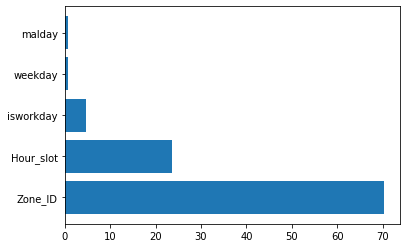

In [9]:
plt.barh(features, model.feature_importances_);

In [10]:
preds = model.predict(val_df[features])
preds = np.maximum(0, preds)
rmse(preds, val_df.Hire_count)

6.00542863126738

In [11]:
preds = model.predict(test_df[features])
preds = np.maximum(0, preds)
test_df['Hire_count'] = preds
sub_df = test_df[['Test_ID', 'Zone_ID', 'Date', 'Hour_slot', 'Hire_count']]
sub_df.to_csv('predict.csv', index=False)
sub_df

,Test_ID,Zone_ID,Date,Hour_slot,Hire_count
0,0,7,2017-02-01,0,1.089819
1,1,7,2017-02-01,1,0.482928
2,2,7,2017-02-01,2,0.310607
3,3,7,2017-02-01,3,1.670357
4,4,7,2017-02-01,4,0.000000
...,...,...,...,...,...
6043,6043,19,2017-02-28,19,21.391859
6044,6044,19,2017-02-28,20,19.454968
6045,6045,19,2017-02-28,21,18.664787
6046,6046,19,2017-02-28,22,17.395518


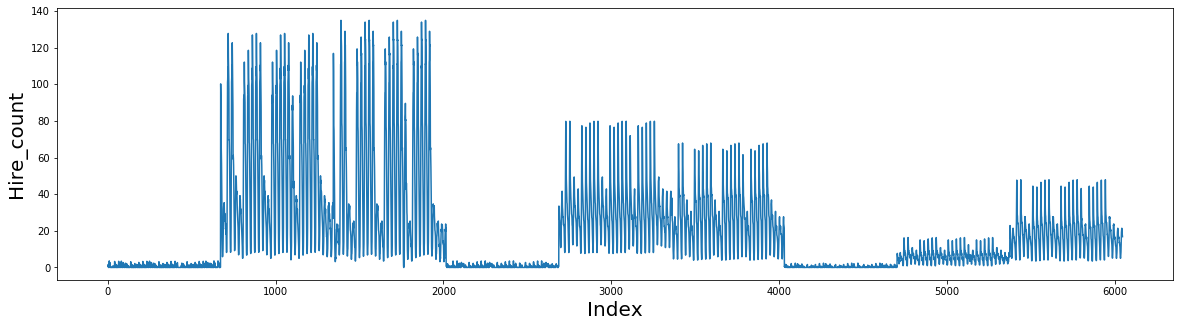

In [12]:
plt.figure(figsize=(20,5))
plt.xlabel('Index',fontsize=20)
plt.ylabel('Hire_count',fontsize=20)
plt.plot(preds)